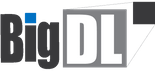

# Vision Transformer Examples for InferenceOptimizer

Today, vison Transformer is becoming more and more popular among computer vision community. On the one hand, people are constantly searching for larger pre-training corpus and pre-training model, on the other hand, how to land the vision transformer in the industrial scene is also a very concerned issue.

Here we take several popular vision Transformer architectures as examples to demonstrate how to use InferenceOptimizer in BigDL-Nano to accelerate inference pipeline.

##  step 0 : Prepare the environment
We recommend you to use [Anaconda](https://www.anaconda.com/distribution/#linux) to prepare the environment.

**Note**: during your installation, there may be some warnings or errors about version, just ignore them.
```bash
conda create -n nano python=3.7  # "nano" is conda environment name, you can use any name you like.
conda activate nano
pip install jsonargparse[signatures]
pip install --pre --upgrade bigdl-nano[pytorch]

# bf16 is available only on torch1.12
pip install torch==1.12.0 torchvision --extra-index-url https://download.pytorch.org/whl/cpu 
# Necessary packages for inference accelaration
pip install --upgrade intel-extension-for-pytorch
pip install onnx==1.12.0 onnxruntime==1.12.1 onnxruntime-extensions
pip install openvino-dev
pip install neural-compressor==1.12
pip install --upgrade numpy==1.21.6
```

Initialize environment variables with script `bigdl-nano-init` installed with bigdl-nano, then unset environment variable `KMP_AFFINITY`.

```bash
source bigdl-nano-init
unset KMP_AFFINITY
``` 

You may find environment variables set like follows:

```
Setting OMP_NUM_THREADS...
Setting OMP_NUM_THREADS specified for pytorch...
Setting KMP_AFFINITY...
Setting KMP_BLOCKTIME...
Setting MALLOC_CONF...
+++++ Env Variables +++++
LD_PRELOAD=./../lib/libjemalloc.so
MALLOC_CONF=oversize_threshold:1,background_thread:true,metadata_thp:auto,dirty_decay_ms:-1,muzzy_decay_ms:-1
OMP_NUM_THREADS=112
KMP_AFFINITY=granularity=fine,compact,1,0
KMP_BLOCKTIME=1
TF_ENABLE_ONEDNN_OPTS=
+++++++++++++++++++++++++
Complete.
```

## step 1 : Prepare Dataset

As InferenceOptimizer needs validation data to calculate accuracy metric, we need to download [ImageNet validation dataset](https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar) and [development kit](https://image-net.org/data/ILSVRC/2012/ILSVRC2012_devkit_t12.tar.gz), and place them under directory `./img_data`.

Here we provide a helper function `create_imagenet_val_dataset` to help users create a subset of ImageNet validation dataset.

In [2]:
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader, Subset
import torch
import numpy as np

def create_imagenet_val_dataset(limit_num_samples=None):
    dataset = ImageNet(root="img_data", split="val")
    if limit_num_samples is not None:
        indices = np.random.permutation(len(dataset))[:limit_num_samples]
        dataset = Subset(dataset, indices)
    return dataset

## step 2 : Import related package

[PyTorch Image Models (timm)](https://github.com/rwightman/pytorch-image-models) provides a collection of image models. Here we use some vision Transformer models with pre-trained weights provided by timm to demonstrate acceleration of InferenceOptimizer in BigDL-Nano. 

In [6]:
from bigdl.nano.pytorch import InferenceOptimizer
import timm
from torchmetrics import Accuracy

## step 3 : Define dataloader, model then optimize

### 1. MobileViT

[MobileViT](https://arxiv.org/abs/2110.02178) is a light-weight, general-purpose, and mobile-friendly vision Transformer.

In [14]:
from configparser import Interpolation
from timm.data.loader import create_loader

fake_train_dataset = create_imagenet_val_dataset()
val_dataset = create_imagenet_val_dataset(limit_num_samples=320)
faked_train_dataloader = create_loader(fake_train_dataset,
                                       input_size=256,
                                       # in case we want to evaluate single sample latency, so set batch_size to 1
                                       batch_size=1,
                                       use_prefetcher=False,
                                       no_aug=True,
                                       crop_pct=0.9,
                                       interpolation="bicubic",
                                       mean=(0.0, 0.0, 0.0),
                                       std=(1.0, 1.0, 1.0),
                                       persistent_workers=False)
val_dataloader = create_loader(val_dataset,
                               input_size=256,
                               batch_size=32,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.0, 0.0, 0.0),
                               std=(1.0, 1.0, 1.0),
                               persistent_workers=False)
val_dataloader.dataset.dataset.transform = val_dataloader.dataset.transform

### Note:
Actually we highly recommand users pass real training dataloader to `training_data` for calibration of quantization.
But as ImageNet training set is too large to download, here we just use validation dataset as faked training dataset.

If you want to get real performance on ImageNet validation set, you can just set `limit_num_samples=None`. Here we choose a subset to make inference pipeline faster and we just want to get a rough metric to evaluate the effect of quantization.

In [15]:
model = timm.create_model("mobilevit_xxs", pretrained=True)

optimizer = InferenceOptimizer()
optimizer.optimize(model,
                   training_data=faked_train_dataloader,
                   validation_data=val_dataloader,
                   metric=Accuracy(),
                   direction="max",
                   thread_num=1)
acc_model, option = optimizer.get_best_model(accuracy_criterion=0.05)
print("best option is ", option)
# print(acc_model(next(iter(val_dataloader))[0]).argmax())

==========================Start Optimization==========================
----------Start test original model (1/13)----------
----------Finish test original model (1/13)----------
----------Start test fp32_ipex model (2/13)----------
----------Finish test fp32_ipex model (2/13)----------
----------Start test bf16 model (3/13)----------


2022-09-14 10:03:10 [ERROR] 

****************************Usage Error************************
Your machine or OS doesn't support BF16 instructions.
[ ERROR ]  

****************************Usage Error************************
Your machine or OS doesn't support BF16 instructions.
2022-09-14 10:03:10 [ERROR] 

**************************How to fix***********************
Please check your machine and OS to make sure BF16 support is available.
[ ERROR ]  

**************************How to fix***********************
Please check your machine and OS to make sure BF16 support is available.
2022-09-14 10:03:10 [ERROR] 

****************************Call Stack*************************
[ ERROR ]  

****************************Call Stack*************************


----------Start test bf16_ipex model (4/13)----------
----------Start test int8 model (5/13)----------
----------Finish test int8 model (5/13)----------
----------Start test jit_fp32 model (6/13)----------
----------Finish test jit_fp32 model (6/13)----------
----------Start test jit_fp32_ipex model (7/13)----------
----------Finish test jit_fp32_ipex model (7/13)----------
----------Start test jit_fp32_ipex_channels_last model (8/13)----------
----------Finish test jit_fp32_ipex_channels_last model (8/13)----------
----------Start test openvino_fp32 model (9/13)----------


[ WARNING ]  
Detected not satisfied dependencies:
	numpy: installed: 1.21.6, required: < 1.20

Please install required versions of components or run pip installation
pip install openvino-dev


[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /tmp/tmps802xcxh/tmp.xml
[ SUCCESS ] BIN file: /tmp/tmps802xcxh/tmp.bin
[ SUCCESS ] Total execution time: 0.77 seconds. 
[ SUCCESS ] Memory consumed: 120 MB. 
----------Finish test openvino_fp32 model (9/13)----------
----------Start test openvino_int8 model (10/13)----------


[ WARNING ]  
Detected not satisfied dependencies:
	numpy: installed: 1.21.6, required: < 1.20

Please install required versions of components or run pip installation
pip install openvino-dev


[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /tmp/tmpgw2wys7v/tmp.xml
[ SUCCESS ] BIN file: /tmp/tmpgw2wys7v/tmp.bin
[ SUCCESS ] Total execution time: 0.79 seconds. 
[ SUCCESS ] Memory consumed: 119 MB. 
----------Finish test openvino_int8 model (10/13)----------
----------Start test onnxruntime_fp32 model (11/13)----------
----------Finish test onnxruntime_fp32 model (11/13)----------
----------Start test onnxruntime_int8_qlinear model (12/13)----------
----------Finish test onnxruntime_int8_qlinear model (12/13)----------
----------Start test onnxruntime_int8_integer model (13/13)----------


2022-09-14 10:06:04 [ERROR] Unexpected exception IndexError('list index (2) out of range') happened during tuning.
[ ERROR ]  Unexpected exception IndexError('list index (2) out of range') happened during tuning.
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/experimental/quantization.py", line 148, in execute
    self.strategy.traverse()
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/strategy/strategy.py", line 402, in traverse
    tune_cfg, self.model, self.calib_dataloader, self.q_func)
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/utils/utility.py", line 262, in fi
    res = func(*args, **kwargs)
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/adaptor/onnxrt.py", line 168, in quantize
    quantizer.quantize_model()
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/adaptor/ox_utils/quantizer.py

Found no quantized model satisfying accuracy criterion.
----------Failed to convert to onnxruntime_int8_integer----------


==========================Optimization Results==========================
 -------------------------------- ---------------------- -------------- ------------
|             method             |        status        | latency(ms)  |  accuracy  |
 -------------------------------- ---------------------- -------------- ------------
|            original            |      successful      |    25.371    |    0.7     |
|           fp32_ipex            |      successful      |    27.616    |    0.7     |
|              bf16              |   fail to forward    |     None     |    None    |
|           bf16_ipex            |        pruned        |   741.684    |    None    |
|              int8              |      successful      |    26.445    |   0.003    |
|            jit_fp32            |      successful      |    20.644    |    0.7     |
|         jit_fp32_ipex        

### 2. PoolFormer

[PoolFormer](https://arxiv.org/abs/2111.11418) verifys that the general architecture of the Transformers, instead of the specific token mixer module, is more essential to the model's performance.

In [10]:
from configparser import Interpolation
from timm.data.loader import create_loader

fake_train_dataset = create_imagenet_val_dataset()
val_dataset = create_imagenet_val_dataset(limit_num_samples=320)
faked_train_dataloader = create_loader(fake_train_dataset,
                               input_size=224,
                               batch_size=1,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.485, 0.456, 0.406),
                               std=(0.229, 0.224, 0.225),
                               persistent_workers=False)
val_dataloader = create_loader(val_dataset,
                               input_size=224,
                               batch_size=32,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.485, 0.456, 0.406),
                               std=(0.229, 0.224, 0.225),
                               persistent_workers=False)
val_dataloader.dataset.dataset.transform = val_dataloader.dataset.transform

In [13]:
model = timm.create_model("poolformer_s12", pretrained=True)

optimizer = InferenceOptimizer()
optimizer.optimize(model,
                   training_data=faked_train_dataloader,
                   validation_data=val_dataloader,
                   metric=Accuracy(),
                   direction="max",
                   thread_num=1)
acc_model, option = optimizer.get_best_model(accuracy_criterion=0.05)
print("best option is ", option)
# print(acc_model(next(iter(val_dataloader))[0]).argmax())

==========================Start Optimization==========================
----------Start test original model (1/13)----------
----------Finish test original model (1/13)----------
----------Start test fp32_ipex model (2/13)----------
----------Finish test fp32_ipex model (2/13)----------
----------Start test bf16 model (3/13)----------


2022-09-14 09:54:02 [ERROR] 

****************************Usage Error************************
Your machine or OS doesn't support BF16 instructions.
[ ERROR ]  

****************************Usage Error************************
Your machine or OS doesn't support BF16 instructions.
2022-09-14 09:54:02 [ERROR] 

**************************How to fix***********************
Please check your machine and OS to make sure BF16 support is available.
[ ERROR ]  

**************************How to fix***********************
Please check your machine and OS to make sure BF16 support is available.
2022-09-14 09:54:02 [ERROR] 

****************************Call Stack*************************
[ ERROR ]  

****************************Call Stack*************************


----------Start test bf16_ipex model (4/13)----------
----------Start test int8 model (5/13)----------


2022-09-14 09:54:17 [ERROR] Unexpected exception AttributeError("'GraphModule' object has no attribute 'network.0.0.layer_scale_1'") happened during tuning.
[ ERROR ]  Unexpected exception AttributeError("'GraphModule' object has no attribute 'network.0.0.layer_scale_1'") happened during tuning.
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/experimental/quantization.py", line 148, in execute
    self.strategy.traverse()
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/strategy/strategy.py", line 402, in traverse
    tune_cfg, self.model, self.calib_dataloader, self.q_func)
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/utils/utility.py", line 262, in fi
    res = func(*args, **kwargs)
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/adaptor/pytorch.py", line 2658, in quantize
    self._get_scale_zeropoint(q_model._model, q_model

Found no quantized model satisfying accuracy criterion.
----------Failed to convert to int8----------
----------Start test jit_fp32 model (6/13)----------
----------Start test jit_fp32_ipex model (7/13)----------
----------Start test jit_fp32_ipex_channels_last model (8/13)----------
----------Start test openvino_fp32 model (9/13)----------


[ WARNING ]  
Detected not satisfied dependencies:
	numpy: installed: 1.21.6, required: < 1.20

Please install required versions of components or run pip installation
pip install openvino-dev


[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /tmp/tmpk2abopzq/tmp.xml
[ SUCCESS ] BIN file: /tmp/tmpk2abopzq/tmp.bin
[ SUCCESS ] Total execution time: 0.70 seconds. 
[ SUCCESS ] Memory consumed: 176 MB. 
----------Finish test openvino_fp32 model (9/13)----------
----------Start test openvino_int8 model (10/13)----------


[ WARNING ]  
Detected not satisfied dependencies:
	numpy: installed: 1.21.6, required: < 1.20

Please install required versions of components or run pip installation
pip install openvino-dev


[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /tmp/tmpttu1d3xz/tmp.xml
[ SUCCESS ] BIN file: /tmp/tmpttu1d3xz/tmp.bin
[ SUCCESS ] Total execution time: 0.70 seconds. 
[ SUCCESS ] Memory consumed: 177 MB. 
----------Finish test openvino_int8 model (10/13)----------
----------Start test onnxruntime_fp32 model (11/13)----------
----------Finish test onnxruntime_fp32 model (11/13)----------
----------Start test onnxruntime_int8_qlinear model (12/13)----------
----------Finish test onnxruntime_int8_qlinear model (12/13)----------
----------Start test onnxruntime_int8_integer model (13/13)----------


2022-09-14 09:56:26 [ERROR] Unexpected exception IndexError('list index (2) out of range') happened during tuning.
[ ERROR ]  Unexpected exception IndexError('list index (2) out of range') happened during tuning.
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/experimental/quantization.py", line 148, in execute
    self.strategy.traverse()
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/strategy/strategy.py", line 402, in traverse
    tune_cfg, self.model, self.calib_dataloader, self.q_func)
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/utils/utility.py", line 262, in fi
    res = func(*args, **kwargs)
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/adaptor/onnxrt.py", line 168, in quantize
    quantizer.quantize_model()
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/adaptor/ox_utils/quantizer.py

Found no quantized model satisfying accuracy criterion.
----------Failed to convert to onnxruntime_int8_integer----------


==========================Optimization Results==========================
 -------------------------------- ---------------------- -------------- ------------
|             method             |        status        | latency(ms)  |  accuracy  |
 -------------------------------- ---------------------- -------------- ------------
|            original            |      successful      |    47.666    |   0.753    |
|           fp32_ipex            |      successful      |    47.772    |   0.753    |
|              bf16              |   fail to forward    |     None     |    None    |
|           bf16_ipex            |        pruned        |   1273.455   |    None    |
|              int8              |   fail to convert    |     None     |    None    |
|            jit_fp32            |        pruned        |   446.669    |    None    |
|         jit_fp32_ipex        

### 3. Swin Transformer

[Swin Transformer](https://arxiv.org/abs/2103.14030) proposes hierarchical vision Transformer using shifted windows.

In [8]:
from configparser import Interpolation
from timm.data.loader import create_loader

fake_train_dataset = create_imagenet_val_dataset()
val_dataset = create_imagenet_val_dataset(limit_num_samples=20)
faked_train_dataloader = create_loader(fake_train_dataset,
                               input_size=224,
                               batch_size=1,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.485, 0.456, 0.406),
                               std=(0.229, 0.224, 0.225),
                               persistent_workers=False)
# swin don't support dynamic batch, so the batch_size of faked_train_dataloader must be the same with val_dataloader
# otherwise the accuracy will be really slow.
val_dataloader = create_loader(val_dataset,
                               input_size=224,
                               batch_size=1,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.485, 0.456, 0.406),
                               std=(0.229, 0.224, 0.225),
                               persistent_workers=False)
val_dataloader.dataset.dataset.transform = val_dataloader.dataset.transform

In [9]:
model = timm.create_model("swin_base_patch4_window7_224", pretrained=True)

optimizer = InferenceOptimizer()
optimizer.optimize(model,
                   training_data=faked_train_dataloader,
                   validation_data=val_dataloader,
                   metric=Accuracy(),
                   direction="max",
                   thread_num=1)
acc_model, option = optimizer.get_best_model(accuracy_criterion=0.05)
print("best option is ", option)
# print(acc_model(next(iter(val_dataloader))[0]).argmax())

==========================Start Optimization==========================
----------Start test original model (1/13)----------
----------Finish test original model (1/13)----------
----------Start test fp32_ipex model (2/13)----------
----------Finish test fp32_ipex model (2/13)----------
----------Start test bf16 model (3/13)----------


2022-09-14 09:39:24 [ERROR] 

****************************Usage Error************************
Your machine or OS doesn't support BF16 instructions.
[ ERROR ]  

****************************Usage Error************************
Your machine or OS doesn't support BF16 instructions.
2022-09-14 09:39:24 [ERROR] 

**************************How to fix***********************
Please check your machine and OS to make sure BF16 support is available.
[ ERROR ]  

**************************How to fix***********************
Please check your machine and OS to make sure BF16 support is available.
2022-09-14 09:39:24 [ERROR] 

****************************Call Stack*************************
[ ERROR ]  

****************************Call Stack*************************


----------Start test bf16_ipex model (4/13)----------
----------Start test int8 model (5/13)----------
----------Finish test int8 model (5/13)----------
----------Start test jit_fp32 model (6/13)----------
----------Finish test jit_fp32 model (6/13)----------
----------Start test jit_fp32_ipex model (7/13)----------
----------Finish test jit_fp32_ipex model (7/13)----------
----------Start test jit_fp32_ipex_channels_last model (8/13)----------
----------Finish test jit_fp32_ipex_channels_last model (8/13)----------
----------Start test openvino_fp32 model (9/13)----------


[ WARNING ]  
Detected not satisfied dependencies:
	numpy: installed: 1.21.6, required: < 1.20

Please install required versions of components or run pip installation
pip install openvino-dev


[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /tmp/tmp3z67y07f/tmp.xml
[ SUCCESS ] BIN file: /tmp/tmp3z67y07f/tmp.bin
[ SUCCESS ] Total execution time: 3.97 seconds. 
[ SUCCESS ] Memory consumed: 801 MB. 
----------Finish test openvino_fp32 model (9/13)----------
----------Start test openvino_int8 model (10/13)----------


[ WARNING ]  
Detected not satisfied dependencies:
	numpy: installed: 1.21.6, required: < 1.20

Please install required versions of components or run pip installation
pip install openvino-dev


[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /tmp/tmprvdjr6c9/tmp.xml
[ SUCCESS ] BIN file: /tmp/tmprvdjr6c9/tmp.bin
[ SUCCESS ] Total execution time: 4.00 seconds. 
[ SUCCESS ] Memory consumed: 800 MB. 
----------Finish test openvino_int8 model (10/13)----------
----------Start test onnxruntime_fp32 model (11/13)----------
----------Finish test onnxruntime_fp32 model (11/13)----------
----------Start test onnxruntime_int8_qlinear model (12/13)----------
----------Finish test onnxruntime_int8_qlinear model (12/13)----------
----------Start test onnxruntime_int8_integer model (13/13)----------


2022-09-14 09:51:12 [ERROR] Unexpected exception IndexError('list index (2) out of range') happened during tuning.
[ ERROR ]  Unexpected exception IndexError('list index (2) out of range') happened during tuning.
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/experimental/quantization.py", line 148, in execute
    self.strategy.traverse()
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/strategy/strategy.py", line 402, in traverse
    tune_cfg, self.model, self.calib_dataloader, self.q_func)
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/utils/utility.py", line 262, in fi
    res = func(*args, **kwargs)
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/adaptor/onnxrt.py", line 168, in quantize
    quantizer.quantize_model()
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/adaptor/ox_utils/quantizer.py

Found no quantized model satisfying accuracy criterion.
----------Failed to convert to onnxruntime_int8_integer----------


==========================Optimization Results==========================
 -------------------------------- ---------------------- -------------- ------------
|             method             |        status        | latency(ms)  |  accuracy  |
 -------------------------------- ---------------------- -------------- ------------
|            original            |      successful      |   297.254    |    1.0     |
|           fp32_ipex            |      successful      |   308.671    |    1.0     |
|              bf16              |   fail to forward    |     None     |    None    |
|           bf16_ipex            |        pruned        |    705.62    |    None    |
|              int8              |      successful      |   178.878    |    0.95    |
|            jit_fp32            |      successful      |    273.09    |    1.0     |
|         jit_fp32_ipex        